In [12]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [ ]:
Use cryptodata_social_cryptocompare, BTC-USD dataset

In [91]:
# get market info for bitcoin from the start of 2016 to the current day

social_media_info = pd.read_csv('cryptodata_social_cryptocompare.csv')
social_media_info.index

RangeIndex(start=0, stop=2001, step=1)

In [92]:
market_info = pd.read_csv('BTC-USD.csv')
market_info.index

RangeIndex(start=0, stop=2434, step=1)

In [93]:
# first 567 contains zeros
social_media_info = social_media_info[567:2001:1]

In [94]:
social_media_info.head()

,Unnamed: 0,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors,time
567,567,5634,2370,5851,261865,722156,53665,73188,141558,26634,66635,5206,1089042,31479,597,194066,105,2783,76,18775,230517,4748,23.10,554.38,351.56,8437.50,15817,9804,1765,229,8282,686,3537,0,5/26/2017
568,568,5827,2427,5990,268695,746321,54589,75038,146799,27456,69720,5292,1125215,31505,565,195011,105,2787,76,18781,231470,15977,13.78,330.62,172.08,4130.02,15853,9820,1766,234,8283,688,3539,0,5/27/2017
569,569,5873,2443,6090,272055,762354,55312,76280,151348,27911,71133,5352,1149690,31539,533,195817,105,2795,76,18787,232185,3070,14.01,336.20,138.09,3314.15,15876,9837,1766,234,8284,685,3543,0,5/28/2017
570,570,5896,2458,6199,275385,777977,55917,77388,154664,28556,72482,5397,1172381,31560,453,196623,105,2795,76,18793,232777,3448,15.27,366.41,267.86,6428.57,15904,9845,1770,235,8286,686,3545,0,5/29/2017
571,571,5958,2471,6318,279305,793113,56560,78481,158590,29580,73833,5447,1195604,31582,359,197387,105,2801,76,18799,233336,4480,18.80,451.25,278.21,6676.97,15932,9866,1778,234,8291,686,3546,0,5/30/2017


In [95]:
social_media_info = social_media_info.dropna(how='any',axis=0) 
social_media_info['time'] = pd.to_datetime(social_media_info['time'])
social_media_info = social_media_info.sort_values(by='time')

In [96]:
market_info = market_info.dropna(how='any',axis=0)
market_info['Date'] = pd.to_datetime(market_info['Date'])
market_info = market_info.sort_values(by='Date')

In [97]:
# social media first row's date is 2017-05-26, and last row's date is 2021-04-28
market_info = market_info[(market_info['Date'] >= '2017-05-26') & (market_info['Date'] <= '2021-04-28')]

In [98]:
# join 2 datasets into 1 over Date field
market_info = market_info[market_info['Date'].notnull() == True].set_index('Date')
social_media_info = social_media_info[social_media_info['time'].notnull() == True].set_index('time')
dataset = market_info.join(social_media_info, how='right')

In [99]:
dataset.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Unnamed: 0',
       'comments', 'posts', 'followers', 'points', 'overview_page_views',
       'analysis_page_views', 'markets_page_views', 'charts_page_views',
       'trades_page_views', 'forum_page_views', 'influence_page_views',
       'total_page_views', 'fb_likes', 'fb_talking_about', 'twitter_followers',
       'twitter_following', 'twitter_lists', 'twitter_favourites',
       'twitter_statuses', 'reddit_subscribers', 'reddit_active_users',
       'reddit_posts_per_hour', 'reddit_posts_per_day',
       'reddit_comments_per_hour', 'reddit_comments_per_day',
       'code_repo_stars', 'code_repo_forks', 'code_repo_subscribers',
       'code_repo_open_pull_issues', 'code_repo_closed_pull_issues',
       'code_repo_open_issues', 'code_repo_closed_issues',
       'code_repo_contributors'],
      dtype='object')

In [103]:
dataset['time']

KeyError: ignored

In [105]:
dataset = dataset.loc[:, ~dataset.columns.str.contains('^Unnamed')]

In [109]:
# .index indicates the 'time' column
dataset.index

DatetimeIndex(['2017-05-26', '2017-05-27', '2017-05-28', '2017-05-29',
               '2017-05-30', '2017-05-31', '2017-06-01', '2017-06-02',
               '2017-06-03', '2017-06-04',
               ...
               '2021-04-19', '2021-04-20', '2021-04-21', '2021-04-22',
               '2021-04-23', '2021-04-24', '2021-04-25', '2021-04-26',
               '2021-04-27', '2021-04-28'],
              dtype='datetime64[ns]', name='time', length=1434, freq=None)

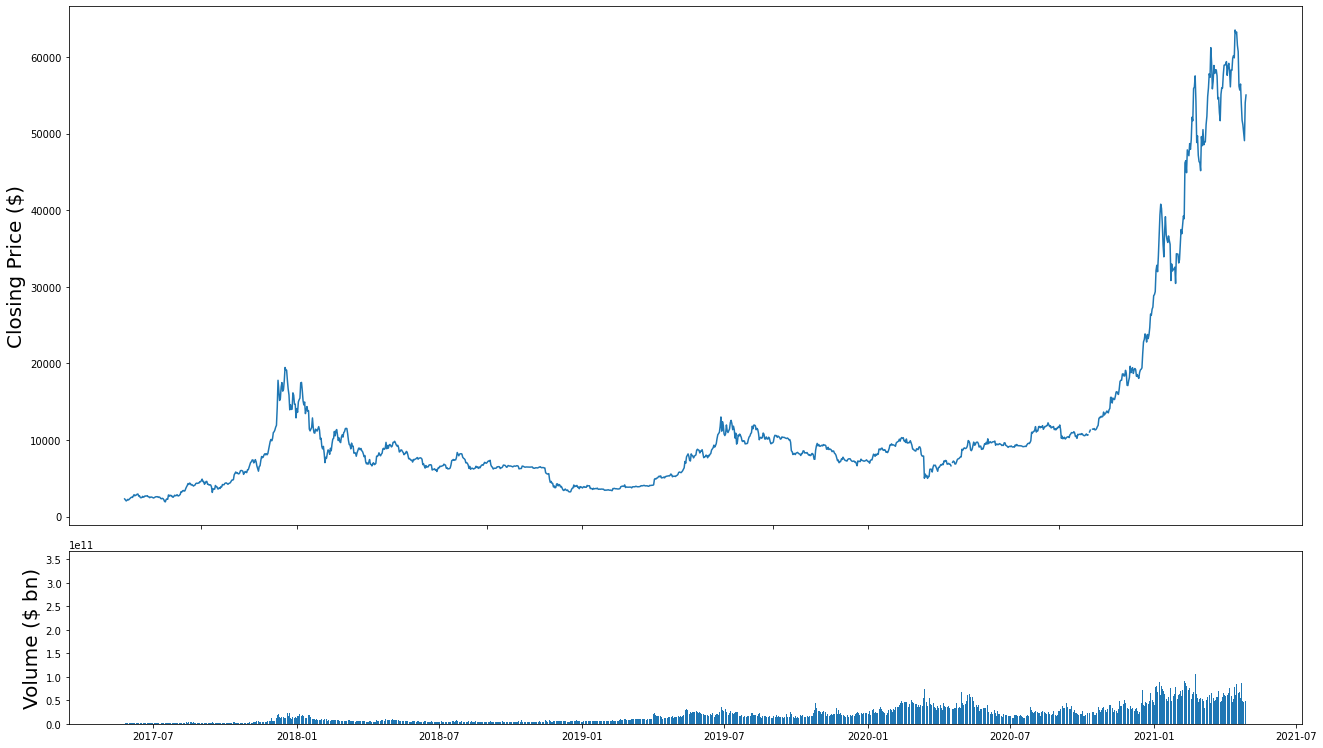

In [110]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
#ax1.set_yscale('log')
ax1.set_ylabel('Closing Price ($)',fontsize=20)
ax2.set_ylabel('Volume ($ bn)',fontsize=20)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,9]])
ax1.set_xticklabels('')
ax1.plot(dataset.index,dataset['Open'])
ax2.bar(dataset.index, dataset['Volume'].values)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()

plt.show()

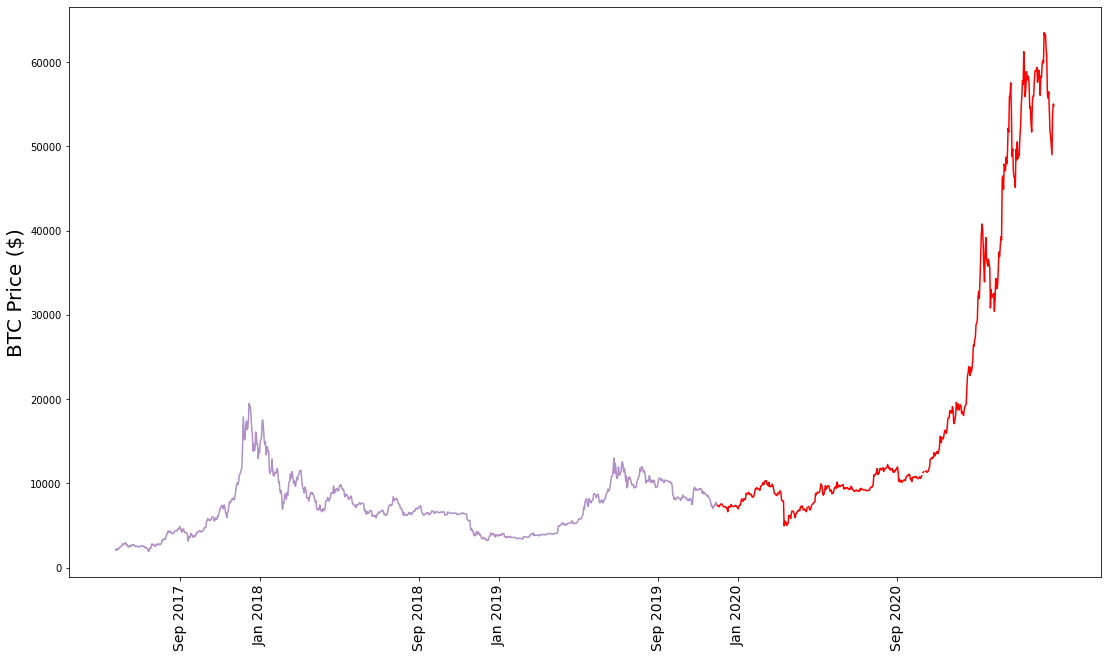

In [111]:
split_date = '2019-12-01'
fig, (ax2) = plt.subplots(1,1)
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,9]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2021) for j in [1,9]])
ax2.plot(dataset[dataset.index < split_date].index,
         dataset[dataset.index < split_date]['Close'], 
         color='#B08FC7')
ax2.plot(dataset[dataset.index >= split_date].index,
         dataset[dataset.index >= split_date]['Close'], color='red')
ax2.set_ylabel('BTC Price ($)',fontsize=20)
fig.set_size_inches(18.5, 10.5)
plt.xticks(fontsize=14, rotation=90)
plt.show()

In [112]:
kwargs = {'day_diff': lambda x: (x['Close']-x['Open'])/x['Open'],
          'volatility': lambda x: (x['High']- x['Low'])/(x['Open'])}
dataset = dataset.assign(**kwargs)

In [113]:
training_set, test_set = dataset[dataset.index <split_date], dataset[dataset.index >= split_date]

In [115]:
window_len = 10

In [116]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in ['Close','Volume']:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1

In [117]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in ['Close','Volume']:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

In [118]:
LSTM_training_inputs[0]

,Open,High,Low,Close,Adj Close,Volume,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors,day_diff,volatility
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-05-26,2320.889893,2573.790039,2071.989990,0.000000,2202.419922,0.000000,5634,2370,5851,261865,722156,53665,73188,141558,26634,66635,5206,1089042,31479,597,194066,105,2783,76,18775,230517,4748,23.10,554.38,351.56,8437.50,15817,9804,1765,229,8282,686,3537,0,-0.051045,0.216210
2017-05-27,2196.270020,2260.199951,1855.829956,-0.074259,2038.869995,-0.035725,5827,2427,5990,268695,746321,54589,75038,146799,27456,69720,5292,1125215,31505,565,195011,105,2787,76,18781,231470,15977,13.78,330.62,172.08,4130.02,15853,9820,1766,234,8283,688,3539,0,-0.071667,0.184117
2017-05-28,2054.080078,2267.340088,2054.080078,-0.021168,2155.800049,-0.349502,5873,2443,6090,272055,762354,55312,76280,151348,27911,71133,5352,1149690,31539,533,195817,105,2795,76,18787,232185,3070,14.01,336.20,138.09,3314.15,15876,9837,1766,234,8284,685,3543,0,0.049521,0.103823
2017-05-29,2159.429932,2307.050049,2107.169922,0.024151,2255.610107,-0.435987,5896,2458,6199,275385,777977,55917,77388,154664,28556,72482,5397,1172381,31560,453,196623,105,2795,76,18793,232777,3448,15.27,366.41,267.86,6428.57,15904,9845,1770,235,8286,686,3545,0,0.044540,0.092562
2017-05-30,2255.360107,2301.959961,2124.570068,-0.012237,2175.469971,-0.181182,5958,2471,6318,279305,793113,56560,78481,158590,29580,73833,5447,1195604,31582,359,197387,105,2801,76,18799,233336,4480,18.80,451.25,278.21,6676.97,15932,9866,1778,234,8291,686,3546,0,-0.035422,0.078653
2017-05-31,2187.189941,2311.080078,2145.570068,0.038135,2286.409912,-0.123988,5984,2492,6439,283115,806759,57103,79452,161474,30318,74889,5504,1215499,31612,312,198260,105,2809,76,18805,233909,3978,14.94,358.55,181.73,4361.43,15972,9883,1778,235,8297,688,3551,0,0.045364,0.075672
2017-06-01,2288.330078,2448.389893,2288.330078,0.093288,2407.879883,-0.062547,6011,2502,6544,286260,821755,57692,80620,164441,30867,75829,5546,1236750,31629,252,199074,105,2813,76,18811,234503,5726,8.96,215.02,197.91,4749.86,16012,9908,1782,235,8307,690,3554,0,0.052243,0.069946
2017-06-02,2404.030029,2488.550049,2373.320068,0.129916,2488.550049,-0.253164,6052,2516,6624,289020,832459,58204,81599,166383,31297,76588,5586,1252116,31653,220,199817,105,2817,76,18821,234974,3346,13.57,325.74,148.45,3562.89,16054,9922,1782,233,8314,691,3556,0,0.035158,0.047932
2017-06-03,2493.719971,2581.909912,2423.570068,0.142085,2515.350098,-0.140932,6096,2532,6700,291760,843149,58672,82460,169117,31796,77519,5621,1268334,31685,243,200498,105,2824,76,18827,235465,2701,7.03,168.70,156.45,3754.89,16084,9942,1786,239,8316,691,3556,0,0.008674,0.063495


In [119]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [120]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [121]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
909/909 - 4s - loss: 0.2937
Epoch 2/50
909/909 - 2s - loss: 0.1850
Epoch 3/50
909/909 - 2s - loss: 0.1302
Epoch 4/50
909/909 - 2s - loss: 0.1167
Epoch 5/50
909/909 - 2s - loss: 0.1150
Epoch 6/50
909/909 - 2s - loss: 0.1146
Epoch 7/50
909/909 - 2s - loss: 0.1146
Epoch 8/50
909/909 - 2s - loss: 0.1145
Epoch 9/50
909/909 - 2s - loss: 0.1146
Epoch 10/50
909/909 - 2s - loss: 0.1153
Epoch 11/50
909/909 - 2s - loss: 0.1149
Epoch 12/50
909/909 - 2s - loss: 0.1146
Epoch 13/50
909/909 - 2s - loss: 0.1143
Epoch 14/50
909/909 - 2s - loss: 0.1140
Epoch 15/50
909/909 - 2s - loss: 0.1134
Epoch 16/50
909/909 - 2s - loss: 0.1149
Epoch 17/50
909/909 - 2s - loss: 0.1148
Epoch 18/50
909/909 - 2s - loss: 0.1148
Epoch 19/50
909/909 - 2s - loss: 0.1143
Epoch 20/50
909/909 - 2s - loss: 0.1137
Epoch 21/50
909/909 - 2s - loss: 0.1153
Epoch 22/50
909/909 - 2s - loss: 0.1147
Epoch 23/50
909/909 - 2s - loss: 0.1150
Epoch 24/50
909/909 - 2s - loss: 0.1154
Epoch 25/50
909/909 - 2s - loss: 0.1140
Epoch 26/

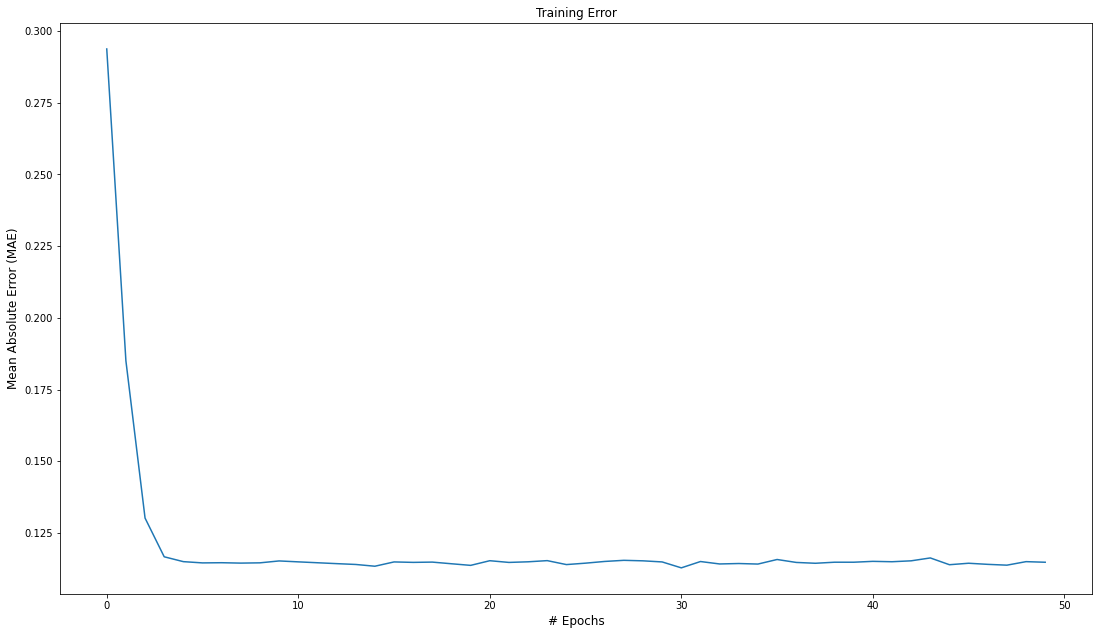

In [122]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
fig.set_size_inches(18.5, 10.5)
plt.show()

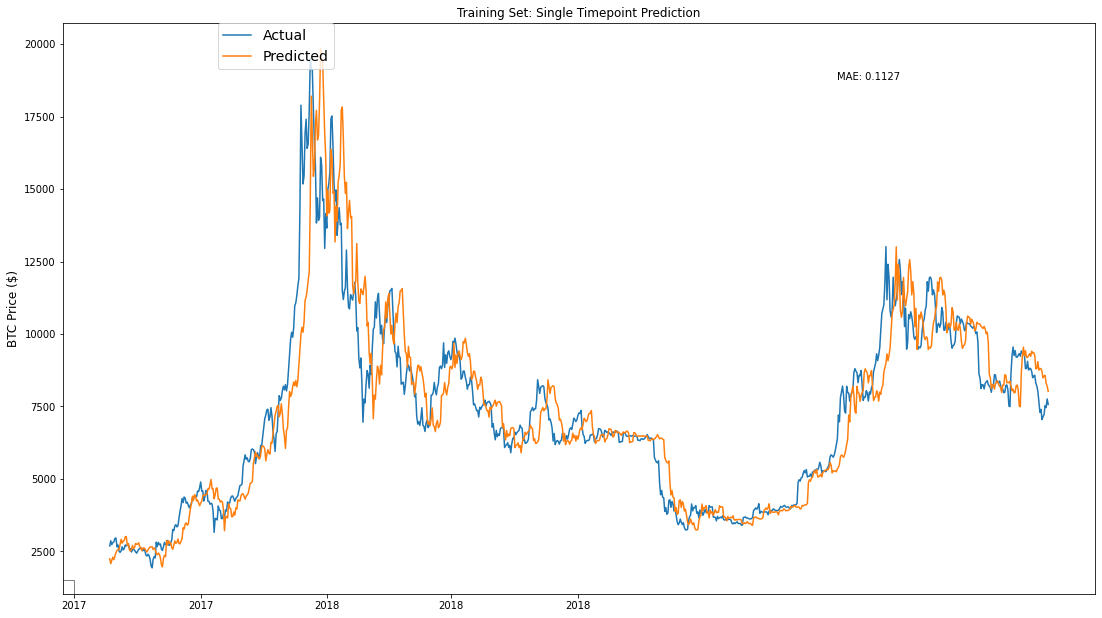

In [125]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
#ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2021) for j in [1,5,9]])
ax1.plot(dataset[dataset.index< split_date].index[window_len:],
         training_set['Close'][window_len:], label='Actual')
ax1.plot(dataset[dataset.index < split_date].index[window_len:],
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('BTC Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_training_inputs))+1)-\
            (training_set['Close'].values[window_len:])/(training_set['Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(dataset[dataset.index< split_date].index[window_len:],
         training_set['Close'][window_len:], label='Actual')
axins.plot(dataset[dataset.index < split_date].index[window_len:],
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 3, 1), datetime.date(2017, 5, 1)])
axins.set_ylim([800,1500])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
fig.set_size_inches(18.5, 10.5)
plt.show()


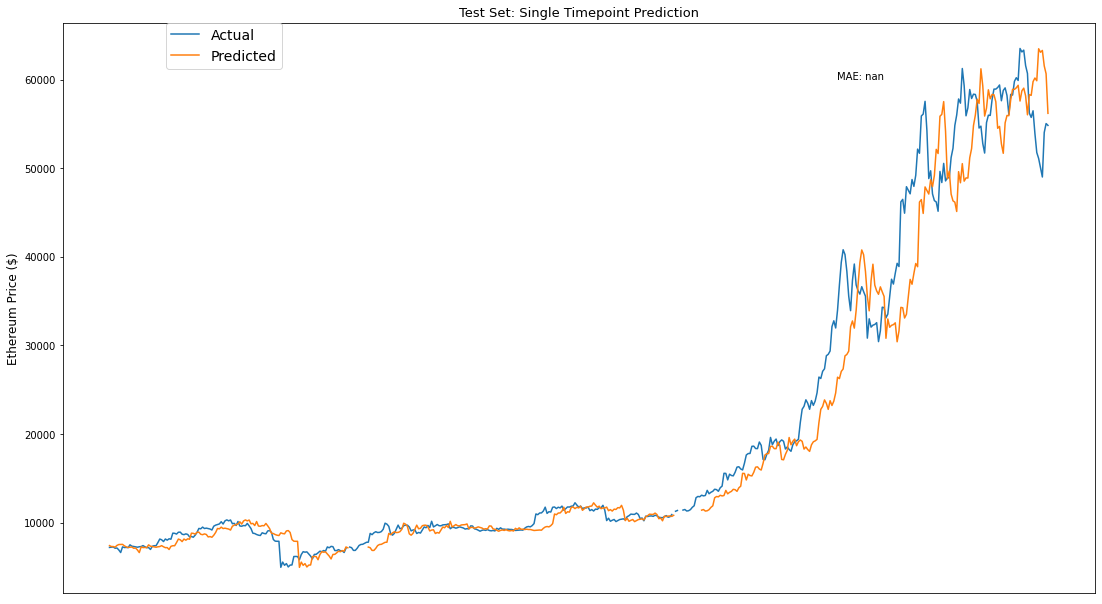

In [127]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(dataset[dataset.index>= split_date].index[window_len:],
         test_set['Close'][window_len:], label='Actual')
ax1.plot(dataset[dataset.index>= split_date].index[window_len:],
         ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['Close'].values[window_len:])/(test_set['Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
fig.set_size_inches(18.5, 10.5)
plt.show()

In [128]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['Close'])-pred_range):
    LSTM_training_outputs.append((training_set['Close'][i:i+pred_range].values/
                                  training_set['Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
904/904 - 3s - loss: 0.2727
Epoch 2/50
904/904 - 2s - loss: 0.1739
Epoch 3/50
904/904 - 2s - loss: 0.1360
Epoch 4/50
904/904 - 2s - loss: 0.1280
Epoch 5/50
904/904 - 2s - loss: 0.1277
Epoch 6/50
904/904 - 2s - loss: 0.1293
Epoch 7/50
904/904 - 2s - loss: 0.1285
Epoch 8/50
904/904 - 2s - loss: 0.1276
Epoch 9/50
904/904 - 2s - loss: 0.1274
Epoch 10/50
904/904 - 2s - loss: 0.1285
Epoch 11/50
904/904 - 2s - loss: 0.1276
Epoch 12/50
904/904 - 2s - loss: 0.1282
Epoch 13/50
904/904 - 2s - loss: 0.1283
Epoch 14/50
904/904 - 2s - loss: 0.1274
Epoch 15/50
904/904 - 2s - loss: 0.1282
Epoch 16/50
904/904 - 2s - loss: 0.1286
Epoch 17/50
904/904 - 2s - loss: 0.1283
Epoch 18/50
904/904 - 2s - loss: 0.1275
Epoch 19/50
904/904 - 2s - loss: 0.1283
Epoch 20/50
904/904 - 2s - loss: 0.1279
Epoch 21/50
904/904 - 2s - loss: 0.1283
Epoch 22/50
904/904 - 2s - loss: 0.1283
Epoch 23/50
904/904 - 2s - loss: 0.1277
Epoch 24/50
904/904 - 2s - loss: 0.1285
Epoch 25/50
904/904 - 2s - loss: 0.1285
Epoch 26/

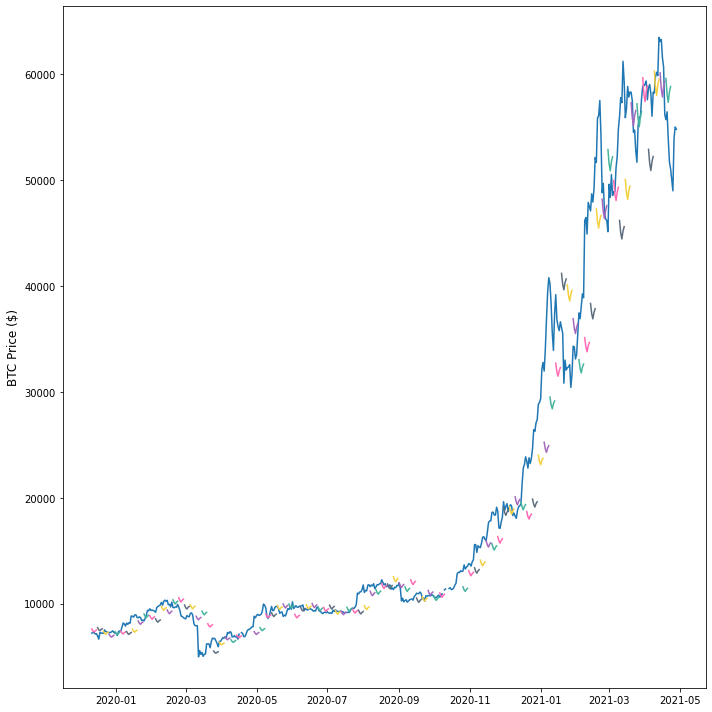

In [129]:
# little bit of reformatting the predictions to closing prices
eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))
pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, (ax2) = plt.subplots(1,1, figsize=(10, 10))

#ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
#ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax2.plot(dataset[dataset.index >= split_date].index[window_len:],
         test_set['Close'][window_len:], label='Actual')
for i, eth_pred in enumerate(eth_pred_prices):
    
    # Only adding lines to the legend once
    if i<5:
        ax2.plot(dataset[dataset.index>= split_date].index[window_len:][i*pred_range:((i*pred_range)+pred_range)],
                 eth_pred, color=pred_colors[i%5], label="Predicted")
    else: 
        ax2.plot(dataset[dataset.index>= split_date].index[window_len:][i*pred_range:i*pred_range+pred_range],
                 eth_pred, color=pred_colors[i%5])
ax2.set_ylabel('BTC Price ($)',fontsize=12)
fig.tight_layout()
plt.show()